# I. Pip Install / Load Libraries / Load Dataset form Hugging face

In [1]:
!pip install datasets torchvision accelerate evaluate

In [2]:
import psutil

# Lấy thông tin RAM (số byte khả dụng)
available_ram = psutil.virtual_memory().available
# Lấy số lượng lõi CPU (logical)
cpu_count = psutil.cpu_count(logical=True)

print(f"Available RAM: {available_ram / (1024**3):.2f} GB")
print(f"CPU count: {cpu_count}")


Available RAM: 26.25 GB
CPU count: 56


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_from_disk

from datasets import load_dataset, Features, Value
from transformers import ViTFeatureExtractor
import torch
from torchvision import transforms
from datasets.features import Image
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/home/ailab1/miniconda3/envs/thanh-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset_dict  = load_dataset("ashraq/fashion-product-images-small")
dataset_dict 

DatasetDict({
    train: Dataset({
        features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
        num_rows: 44072
    })
})

# II. Basic Preprocessing and Understanding Data

In [5]:
train_dataset = dataset_dict["train"]

In [6]:
def assign_price(masterCategory, subCategory, articleType, year, season, usage):
    master_price_range = {
        'Apparel': (10, 20), 'Accessories': (5, 100), 'Footwear': (20, 200),
        'Personal Care': (5, 300), 'Free Items': (0, 5), 'Sporting Goods': (100, 250), 'Home': (100, 300)
    }
    sub_price_adjustment = {
        'Topwear': (5, 50), 'Watches': (30, 150), 'Shoes': (20, 100),
        'Bags': (10, 70), 'Fragrance': (5, 80), 'Jewellery': (10, 200)
    }
    article_price_range = {
        'Shirts': (15, 70), 'Watches': (50, 300), 'Sports Shoes': (40, 200),
        'Sunglasses': (30, 150), 'Perfumes': (25, 120)
    }
    
    # Lấy khoảng giá từ masterCategory
    base_min, base_max = master_price_range.get(masterCategory, (10, 100))
    
    # Điều chỉnh theo subCategory
    adj_min, adj_max = sub_price_adjustment.get(subCategory, (0, 0))
    
    # Điều chỉnh theo articleType
    art_min, art_max = article_price_range.get(articleType, (base_min + adj_min, base_max + adj_max))
    
    # Điều chỉnh theo năm
    if year < 2015:
        discount = 0.3
    elif year < 2018:
        discount = 0.15
    else:
        discount = 0

    final_min = art_min * (1 - discount)
    final_max = art_max * (1 - discount)

    return round(np.random.uniform(final_min, final_max) * 2500, 0)

def add_price_column(example):
    example["price_in_vnd"] = assign_price(
        example["masterCategory"], 
        example["subCategory"], 
        example["articleType"], 
        example["year"], 
        example["season"], 
        example["usage"]
    )
    return example

# Cập nhật dataset với cột price_in_usd
train_dataset = train_dataset.map(add_price_column)

# Kiểm tra 5 dòng đầu tiên sau khi thêm giá
print(train_dataset[:5])


{'id': [15970, 39386, 59263, 21379, 53759], 'gender': ['Men', 'Men', 'Women', 'Men', 'Men'], 'masterCategory': ['Apparel', 'Apparel', 'Accessories', 'Apparel', 'Apparel'], 'subCategory': ['Topwear', 'Bottomwear', 'Watches', 'Bottomwear', 'Topwear'], 'articleType': ['Shirts', 'Jeans', 'Watches', 'Track Pants', 'Tshirts'], 'baseColour': ['Navy Blue', 'Blue', 'Silver', 'Black', 'Grey'], 'season': ['Fall', 'Summer', 'Winter', 'Fall', 'Summer'], 'year': [2011.0, 2012.0, 2016.0, 2011.0, 2012.0], 'usage': ['Casual', 'Casual', 'Casual', 'Casual', 'Casual'], 'productDisplayName': ['Turtle Check Men Navy Blue Shirt', 'Peter England Men Party Blue Jeans', 'Titan Women Silver Watch', 'Manchester United Men Solid Black Track Pants', 'Puma Men Grey T-shirt'], 'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7FB38D581C00>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7FB38D5A0F40>, <PIL.Image.Image image mode=L size=60x80 at 0x7FB38D5DC550>, <PIL.JpegIm

In [7]:
def has_null(example):
    # Kiểm tra xem có giá trị nào trong example bị None không
    return any(val is None for val in example.values())

missing_null = train_dataset.filter(has_null)
print(f"Số record có giá trị null: {len(missing_null)}")


Số record có giá trị null: 0


In [8]:
features = Features({
    'id': Value('int64'),
    'gender': Value('string'),
    'masterCategory': Value('string'),
    'subCategory': Value('string'),
    'articleType': Value('string'),
    'baseColour': Value('string'),
    'season': Value('string'),
    'year': Value('int64'), 
    'usage': Value('string'),
    'productDisplayName': Value('string'),
    'image': Image(),
    'price_in_vnd': Value('int64')
})

# Chuyển đổi dataset với features mới
train_dataset = train_dataset.cast(features)


In [9]:
train_dataset.features 

{'id': Value(dtype='int64', id=None),
 'gender': Value(dtype='string', id=None),
 'masterCategory': Value(dtype='string', id=None),
 'subCategory': Value(dtype='string', id=None),
 'articleType': Value(dtype='string', id=None),
 'baseColour': Value(dtype='string', id=None),
 'season': Value(dtype='string', id=None),
 'year': Value(dtype='int64', id=None),
 'usage': Value(dtype='string', id=None),
 'productDisplayName': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'price_in_vnd': Value(dtype='int64', id=None)}

In [10]:
# df= df.drop(columns= 'token_length')
# df.to_csv(r'/home/ailab1/student_share/Thanh/GPU/Data/df_train.csv', index = False)

In [11]:
df = pd.read_csv(r'/home/ailab1/student_share/Thanh/GPU/Data/df_train.csv')
df

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44067  17036    Men       Footwear       Shoes           Casual Shoes   
44068   6461    Men       Footwear  Flip Flops             Flip Flops   
44069  18842    Men        Apparel     Topwear                Tshirts   
44070  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44071  51623  Women    Accessories     Watches                Watches   

      baseColour  season  year   usage  \
0      Navy Blue    Fall  2011  Casual   
1           Blue  Summer  2012  Casual   
2         Silver  Winter  2016  Casual   
3          Black    Fall  2011  Casual   
4           Grey  Summer  2012  Casual   
...          ...     ...   ...     ...   
44067      White  Summer  2013  Casual   
44068        Red  Summer  2011  Casual   
44069       Blue    Fall  2011  Casual   
44070       Blue  Spring  2017  Casual   
44071       Pink  Winter  2016  Casual   

                                    productDisplayName  \
0                     Turtle Check Men Navy Blue Shirt   
1                   Peter England Men Party Blue Jeans   
2                             Titan Women Silver Watch   
3        Manchester United Men Solid Black Track Pants   
4                                Puma Men Grey T-shirt   
...                                                ...   
44067                        Gas Men Caddy Casual Shoe   
44068               Lotto Men's Soccer Track Flip Flop   
44069             Puma Men Graphic Stellar Blue Tshirt   
44070                   Rasasi Women Blue Lady Perfume   
44071  Fossil Women Pink Dial Chronograph Watch ES3050   

                                                   image  price_in_vnd  
0      <PIL.JpegImagePlugin.JpegImageFile image mode=...         65852  
1      <PIL.JpegImagePlugin.JpegImageFile image mode=...         22248  
2      <PIL.Image.Image image mode=L size=60x80 at 0x...        599514  
3      <PIL.JpegImagePlugin.JpegImageFile image mode=...         33229  
4      <PIL.Image.Image image mode=RGB size=60x80 at ...         40863  
...                                                  ...           ...  
44067  <PIL.Image.Image image mode=RGB size=60x80 at ...        440590  
44068  <PIL.JpegImagePlugin.JpegImageFile image mode=...        272071  
44069  <PIL.JpegImagePlugin.JpegImageFile image mode=...         29938  
44070  <PIL.Image.Image image mode=RGB size=60x80 at ...        677828  
44071  <PIL.Image.Image image mode=RGB size=60x80 at ...        619905  

[44072 rows x 12 columns]

In [12]:
cols = [ 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName']
for col in cols:
    print(f"Number of categoricals in -{col}-: {df[col].nunique()}")
    print(f"Categoricals Label is: {df[col].unique()}")
    print("="*30)


# Data Columns that have Ordinal:
# year: 2007-2019
# seasons: Spring, Summer, Fall, Winter

Number of categoricals in -gender-: 5
Categoricals Label is: ['Men' 'Women' 'Boys' 'Girls' 'Unisex']
Number of categoricals in -masterCategory-: 7
Categoricals Label is: ['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']
Number of categoricals in -subCategory-: 45
Categoricals Label is: ['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewellery'
 'Lips' 'Saree' 'Eyewear' 'Scarves' 'Dress' 'Loungewear and Nightwear'
 'Wallets' 'Apparel Set' 'Headwear' 'Mufflers' 'Skin Care' 'Makeup'
 'Free Gifts' 'Ties' 'Accessories' 'Nails' 'Beauty Accessories'
 'Water Bottle' 'Skin' 'Eyes' 'Bath and Body' 'Gloves'
 'Sports Accessories' 'Cufflinks' 'Sports Equipment' 'Stoles' 'Hair'
 'Perfumes' 'Home Furnishing' 'Umbrellas' 'Wristbands' 'Vouchers']
Number of categoricals in -articleType-: 141
Categoricals Label is: ['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual

## 2.1 Define Length in ProductDisplayName

In [13]:
df['token_length'] = df['productDisplayName'].apply(lambda x: len(tokenizer.tokenize(x)))

# Kiểm tra phân phối độ dài token
print(df['token_length'].describe())

count    44072.000000
mean         8.072677
std          2.620897
min          1.000000
25%          6.000000
50%          8.000000
75%         10.000000
max         28.000000
Name: token_length, dtype: float64


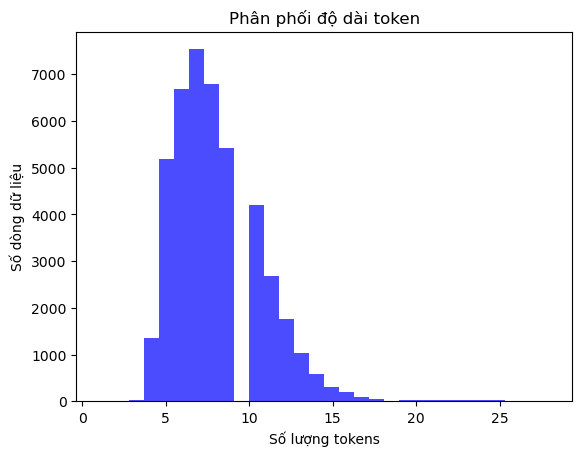

In [14]:
# Vẽ histogram độ dài tokens
plt.hist(df['token_length'], bins=30, color='blue', alpha=0.7)
plt.xlabel("Số lượng tokens")
plt.ylabel("Số dòng dữ liệu")
plt.title("Phân phối độ dài token")
plt.show()

In [15]:
lengths = [len(tokenizer.tokenize(text)) for text in df["productDisplayName"]]
print(f"Độ dài trung bình: {np.mean(lengths)}")
print(f"Độ dài lớn nhất: {np.max(lengths)}")
print(f"90% mô tả có độ dài dưới: {np.percentile(lengths, 90)} tokens")
print(f"95% mô tả có độ dài dưới: {np.percentile(lengths, 95)} tokens")

Độ dài trung bình: 8.072676529315665
Độ dài lớn nhất: 28
90% mô tả có độ dài dưới: 11.0 tokens
95% mô tả có độ dài dưới: 13.0 tokens


## 2.2 Label Encoder

In [16]:
def extract_brand(name, gender):
    # Chuyển đổi sang chữ thường để tìm kiếm không phân biệt hoa thường
    name_lower = name.lower()
    gender_lower = gender.lower()
    # Tách các từ của productDisplayName
    tokens = name.split(" ")
    tokens_lower = name_lower.split(" ")
    if gender_lower in tokens_lower:
        idx = tokens_lower.index(gender_lower)
        brand_tokens = tokens[:idx]  # Lấy tất cả từ trước từ gender
        # Tùy chỉnh: Nếu muốn loại bỏ từ "by" nếu nằm giữa, có thể xử lý thêm
        brand = " ".join(brand_tokens).replace("by", "").strip()
        return brand
    else:
        return tokens[0]

def build_brand_mapping(dataset):
    # Duyệt qua từng productDisplayName và sử dụng cột gender tương ứng
    brands = []
    for name, gender in zip(dataset["productDisplayName"], dataset["gender"]):
        brands.append(extract_brand(name, gender))
    unique_brands = sorted(list(set(brands)))
    mapping = {brand: idx for idx, brand in enumerate(unique_brands)}
    inv_mapping = {idx: brand for brand, idx in mapping.items()}
    return mapping, inv_mapping

In [17]:
# Hàm xây dựng mapping cho một cột
def build_mapping(dataset, col):
    unique_labels = dataset.unique(col)
    unique_labels.sort()  # Sắp xếp để nhất quán (tùy chọn)
    mapping = {label: idx for idx, label in enumerate(unique_labels)}
    inv_mapping = {idx: label for label, idx in mapping.items()}
    return mapping, inv_mapping

# Ví dụ với các cột danh mục:
gender_map, inv_gender_map = build_mapping(train_dataset, "gender")
master_category_map, inv_master_category_map = build_mapping(train_dataset, "masterCategory")
sub_category_map, inv_sub_category_map = build_mapping(train_dataset, "subCategory")
article_type_map, inv_article_type_map = build_mapping(train_dataset, "articleType")
base_colour_map, inv_base_colour_map = build_mapping(train_dataset, "baseColour")
usage_map, inv_usage_map = build_mapping(train_dataset, "usage")

brand_map, inv_brand_map = build_brand_mapping(train_dataset)

# Kiểm tra các mapping:
print("Gender mapping:", gender_map)
print("Master Category mapping:", master_category_map)
print("Sub Category mapping:", sub_category_map)
print("Article Type mapping:", article_type_map)
print("Base Colour mapping:", base_colour_map)
print("Usage mapping:", usage_map)
print("Brand mapping:", brand_map)

Gender mapping: {'Boys': 0, 'Girls': 1, 'Men': 2, 'Unisex': 3, 'Women': 4}
Master Category mapping: {'Accessories': 0, 'Apparel': 1, 'Footwear': 2, 'Free Items': 3, 'Home': 4, 'Personal Care': 5, 'Sporting Goods': 6}
Sub Category mapping: {'Accessories': 0, 'Apparel Set': 1, 'Bags': 2, 'Bath and Body': 3, 'Beauty Accessories': 4, 'Belts': 5, 'Bottomwear': 6, 'Cufflinks': 7, 'Dress': 8, 'Eyes': 9, 'Eyewear': 10, 'Flip Flops': 11, 'Fragrance': 12, 'Free Gifts': 13, 'Gloves': 14, 'Hair': 15, 'Headwear': 16, 'Home Furnishing': 17, 'Innerwear': 18, 'Jewellery': 19, 'Lips': 20, 'Loungewear and Nightwear': 21, 'Makeup': 22, 'Mufflers': 23, 'Nails': 24, 'Perfumes': 25, 'Sandal': 26, 'Saree': 27, 'Scarves': 28, 'Shoe Accessories': 29, 'Shoes': 30, 'Skin': 31, 'Skin Care': 32, 'Socks': 33, 'Sports Accessories': 34, 'Sports Equipment': 35, 'Stoles': 36, 'Ties': 37, 'Topwear': 38, 'Umbrellas': 39, 'Vouchers': 40, 'Wallets': 41, 'Watches': 42, 'Water Bottle': 43, 'Wristbands': 44}
Article Type mapp

In [18]:
train_dataset.features

{'id': Value(dtype='int64', id=None),
 'gender': Value(dtype='string', id=None),
 'masterCategory': Value(dtype='string', id=None),
 'subCategory': Value(dtype='string', id=None),
 'articleType': Value(dtype='string', id=None),
 'baseColour': Value(dtype='string', id=None),
 'season': Value(dtype='string', id=None),
 'year': Value(dtype='int64', id=None),
 'usage': Value(dtype='string', id=None),
 'productDisplayName': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'price_in_vnd': Value(dtype='int64', id=None)}

In [19]:
def update_categorical(example):
    # Cập nhật các cột theo mapping đã xây dựng
    
    example["masterCategory"] = master_category_map[example["masterCategory"]]
    example["subCategory"] = sub_category_map[example["subCategory"]]
    example["articleType"] = article_type_map[example["articleType"]]
    example["baseColour"] = base_colour_map[example["baseColour"]]
    example["usage"] = usage_map[example["usage"]]
    
    # Nếu dataset của bạn vẫn có cột "productDisplayName",
    # ta có thể trích xuất brand từ đó và chuyển sang giá trị số theo mapping:
    extracted = extract_brand(example["productDisplayName"], example["gender"])
    # Lưu ý: nếu không tìm thấy, extract_brand sẽ trả về token đầu tiên
    # và mapping brand có thể đã được xây dựng từ dữ liệu ban đầu.
    example["brand"] = brand_map.get(extracted, -1)  # Nếu không có, đặt giá trị -1 (hoặc giá trị mặc định)
    example["gender"] = gender_map[example["gender"]]
    return example

# Áp dụng hàm cập nhật vào dataset:
train_dataset = train_dataset.map(update_categorical)




In [20]:
# Xác định các cột cần chuẩn hóa
cols_to_min_max_scaler = ['year', 'price_in_vnd']

# Tạo MinMaxScaler
min_max_scaler = MinMaxScaler()

# Chuyển đổi các cột cần scale thành numpy array
scaling_values = np.array([train_dataset[col] for col in cols_to_min_max_scaler]).T  # Chuyển đổi thành ma trận (N, 2)

# Áp dụng MinMaxScaler
scaled_values = min_max_scaler.fit_transform(scaling_values)

# Áp dụng lại vào train_dataset
train_dataset = train_dataset.map(
    lambda x, idx: {
        'year': scaled_values[idx][0], 
        'price_in_vnd': scaled_values[idx][1]
    },
    with_indices=True
)


In [21]:
season_mapping = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3}

# Chuyển đổi season thành số
train_dataset = train_dataset.map(lambda x: {'season': season_mapping[x['season']]})


## 2.3 BERT Tokenizer for Transformer

In [22]:
def tokenize_function(example):
    return tokenizer(example["productDisplayName"], padding="max_length", truncation=True, max_length=13)

train_dataset = train_dataset.map(tokenize_function, batched=True)

In [23]:
train_dataset = train_dataset.remove_columns(["productDisplayName"])


In [24]:
train_dataset.features


{'id': Value(dtype='int64', id=None),
 'gender': Value(dtype='int64', id=None),
 'masterCategory': Value(dtype='int64', id=None),
 'subCategory': Value(dtype='int64', id=None),
 'articleType': Value(dtype='int64', id=None),
 'baseColour': Value(dtype='int64', id=None),
 'season': Value(dtype='int64', id=None),
 'year': Value(dtype='float64', id=None),
 'usage': Value(dtype='int64', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'price_in_vnd': Value(dtype='float64', id=None),
 'brand': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

## 2.4 Preprocess Image

In [25]:
import os
print(os.cpu_count())  # In ra số lõi CPU của máy

56


In [26]:
from transformers import ViTFeatureExtractor
from torchvision import transforms
from PIL import Image

# Load feature extractor của ViT
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Tiền xử lý ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Hàm xử lý dataset
def preprocess_function(batch):
    processed_images = []
    for img in batch["image"]:
        # Nếu img là đường dẫn (string), mở ảnh
        if isinstance(img, str):
            pil_img = Image.open(img).convert("RGB")
        else:
            pil_img = img.convert("RGB")
        processed_images.append(transform(pil_img))
    batch["pixel_values"] = processed_images
    return batch


# Áp dụng tiền xử lý cho dataset
train_dataset = train_dataset.map(
    preprocess_function, 
    batched=True, 
    batch_size=32,       # Tùy chỉnh batch_size phù hợp với tài nguyên của bạn
    num_proc=16,          # Sử dụng 4 process (có thể điều chỉnh lại dựa trên số CPU có sẵn)
    remove_columns=["image"]  # Nếu không cần giữ cột gốc, giúp tiết kiệm bộ nhớ
)
#15min

/home/ailab1/miniconda3/envs/thanh-env/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## 2.5 Save Data

In [27]:
# train_dataset.save_to_disk(r"/home/ailab1/student_share/Thanh/GPU/Data/processed_dataset")

In [28]:
# train_dataset = load_from_disk(r"/home/ailab1/student_share/Thanh/GPU/Data/processed_dataset")

In [29]:
train_dataset.features

{'id': Value(dtype='int64', id=None),
 'gender': Value(dtype='int64', id=None),
 'masterCategory': Value(dtype='int64', id=None),
 'subCategory': Value(dtype='int64', id=None),
 'articleType': Value(dtype='int64', id=None),
 'baseColour': Value(dtype='int64', id=None),
 'season': Value(dtype='int64', id=None),
 'year': Value(dtype='float64', id=None),
 'usage': Value(dtype='int64', id=None),
 'price_in_vnd': Value(dtype='float64', id=None),
 'brand': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'pixel_values': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None)}

In [30]:
train_dataset[0]

{'id': 15970,
 'gender': 2,
 'masterCategory': 1,
 'subCategory': 38,
 'articleType': 103,
 'baseColour': 25,
 'season': 2,
 'year': 0.3333333333333144,
 'usage': 0,
 'price_in_vnd': 0.08152657950315559,
 'brand': 737,
 'input_ids': [101, 13170, 4638, 2273, 3212, 2630, 3797, 102, 0, 0, 0, 0, 0],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 'pixel_values': [[[1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    0.9921568632125854,
   

# III.  Fine-tuning Model (ViT)

In [31]:
available_ram = psutil.virtual_memory().available
cpu_count = psutil.cpu_count(logical=True)
print(f"Available RAM: {available_ram / (1024**3):.2f} GB")
print(f"CPU count: {cpu_count}")

Available RAM: 25.88 GB
CPU count: 56


In [32]:
from transformers import ViTModel
# --- 1. Load mô hình ViT pre-trained ở chế độ 8-bit ---
# Sử dụng bitsandbytes để tải model ở định dạng 8-bit nhằm tiết kiệm bộ nhớ GPU
vit_model = ViTModel.from_pretrained(
    "google/vit-base-patch16-224",
    # load_in_8bit=True,       # 8-bit quantization
    device_map="auto"        # Tự động phân bổ mô hình trên GPU
)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3.1 Xây dựng Mô Hình ViT Tùy Chỉnh (Multi-Task Learning)

In [33]:
import torch.nn as nn

class CustomViTHierarchical(nn.Module):
    def __init__(self,
                 vit_model,
                 num_gender=5,        # Gender mapping: 5 lớp (ví dụ: Boys, Girls, Men, Unisex, Women)
                 num_master=7,        # Master Category mapping: 7 lớp
                 num_usage=8,         # Usage mapping: 8 lớp
                 num_sub=45,          # Sub Category mapping: ví dụ 45 lớp (giảm số lớp nếu cần)
                 num_article=142,     # Article Type mapping: ví dụ 142 lớp
                 num_base=46,         # Base Colour mapping: ví dụ 46 lớp
                 num_brand=820):      # Brand mapping: ví dụ 820 lớp
        super(CustomViTHierarchical, self).__init__()
        # Sử dụng backbone ViT đã tải
        self.vit = vit_model
        hidden_size = self.vit.config.hidden_size  # Thông thường là 768

        # ----- Level 1: Dự đoán Gender, Master Category, Usage -----
        self.head1_gender = nn.Linear(hidden_size, num_gender)
        self.head1_master = nn.Linear(hidden_size, num_master)
        self.head1_usage  = nn.Linear(hidden_size, num_usage)
        # Tổng số đầu ra của Level 1
        self.level1_dim = num_gender + num_master + num_usage

        # ----- Level 2: Dự đoán Sub Category -----
        self.head2 = nn.Sequential(
            nn.Linear(hidden_size + self.level1_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_sub)
        )
        self.level2_dim = self.level1_dim + num_sub

        # ----- Level 3: Dự đoán Article Type -----
        self.head3 = nn.Sequential(
            nn.Linear(hidden_size + self.level2_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_article)
        )
        self.level3_dim = self.level2_dim + num_article

        # ----- Level 4: Dự đoán Base Colour và Brand -----
        self.head4 = nn.Sequential(
            nn.Linear(hidden_size + self.level3_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_base + num_brand)
        )
        self.num_base = num_base
        self.num_brand = num_brand

    def forward(self, pixel_values):
        # Trích xuất đặc trưng từ ViT (lấy token CLS)
        outputs = self.vit(pixel_values=pixel_values)
        cls_output = outputs.last_hidden_state[:, 0, :]  # shape: (batch, hidden_size)

        # ---- Level 1: Dự đoán Gender, Master Category, Usage ----
        pred_gender = self.head1_gender(cls_output)  # (batch, num_gender)
        pred_master = self.head1_master(cls_output)  # (batch, num_master)
        pred_usage  = self.head1_usage(cls_output)   # (batch, num_usage)
        # Kết hợp các dự đoán Level 1 thành một vector
        level1_pred = torch.cat([pred_gender, pred_master, pred_usage], dim=1)

        # ---- Level 2: Dự đoán Sub Category ----
        level2_input = torch.cat([cls_output, level1_pred], dim=1)
        pred_sub = self.head2(level2_input)  # (batch, num_sub)
        level2_pred = torch.cat([level1_pred, pred_sub], dim=1)

        # ---- Level 3: Dự đoán Article Type ----
        level3_input = torch.cat([cls_output, level2_pred], dim=1)
        pred_article = self.head3(level3_input)  # (batch, num_article)
        level3_pred = torch.cat([level2_pred, pred_article], dim=1)

        # ---- Level 4: Dự đoán Base Colour và Brand ----
        level4_input = torch.cat([cls_output, level3_pred], dim=1)
        pred_base_brand = self.head4(level4_input)  # (batch, num_base + num_brand)
        # Tách kết quả thành Base Colour và Brand
        pred_base = pred_base_brand[:, :self.num_base]
        pred_brand = pred_base_brand[:, self.num_base:]
        
        return {
            "gender": pred_gender,
            "master": pred_master,
            "usage": pred_usage,
            "sub": pred_sub,
            "article": pred_article,
            "base": pred_base,
            "brand": pred_brand
        }
    
# Khởi tạo mô hình phân cấp, truyền vào backbone ViT đã tải (8-bit)
model = CustomViTHierarchical(vit_model)

## 3.2 Cấu hình huấn luyện

In [34]:
# --- 3. In danh sách các module attention để xác định chỗ inject LoRA ---
print("Danh sách các module chứa 'attn' hoặc 'attention':")
for name, module in model.named_modules():
    if 'attn' in name or 'attention' in name:
        print(name)
        for sub_name, sub_module in module.named_modules():
            print(f"  - {sub_name}")

Danh sách các module chứa 'attn' hoặc 'attention':
vit.encoder.layer.0.attention
  - 
  - attention
  - attention.query
  - attention.key
  - attention.value
  - attention.dropout
  - output
  - output.dense
  - output.dropout
vit.encoder.layer.0.attention.attention
  - 
  - query
  - key
  - value
  - dropout
vit.encoder.layer.0.attention.attention.query
  - 
vit.encoder.layer.0.attention.attention.key
  - 
vit.encoder.layer.0.attention.attention.value
  - 
vit.encoder.layer.0.attention.attention.dropout
  - 
vit.encoder.layer.0.attention.output
  - 
  - dense
  - dropout
vit.encoder.layer.0.attention.output.dense
  - 
vit.encoder.layer.0.attention.output.dropout
  - 
vit.encoder.layer.1.attention
  - 
  - attention
  - attention.query
  - attention.key
  - attention.value
  - attention.dropout
  - output
  - output.dense
  - output.dropout
vit.encoder.layer.1.attention.attention
  - 
  - query
  - key
  - value
  - dropout
vit.encoder.layer.1.attention.attention.query
  - 
vit.encode

In [35]:
from peft import LoraConfig, get_peft_model

# --- 4. Cấu hình và chèn LoRA vào mô hình ---
# Chúng ta áp dụng LoRA vào các projection layers của phần attention trong backbone ViT.
# Vì model của bạn có ViT được lưu trong attribute 'vit', nên tên các module sẽ có tiền tố 'vit.'.
lora_config = LoraConfig(
    r=16,                # Rank của ma trận low-rank
    lora_alpha=32,       # Hệ số scaling cho LoRA
    target_modules=[
        "query",
        "key",
        "value",
        "dense"
    ],
    lora_dropout=0.05,   # Tỉ lệ dropout cho LoRA
    bias="none",         # Không cập nhật bias
    task_type="FEATURE_EXTRACTION"  # Loại nhiệm vụ (điều chỉnh nếu cần)
)

In [36]:
# Chèn LoRA vào mô hình (freeze hầu hết tham số, chỉ cập nhật các tham số LoRA)
model = get_peft_model(model, lora_config)

In [37]:
# --- 5. In số lượng tham số trainable để xác nhận ---
def print_trainable_parameters(model):
    trainable_params = 0
    total_params = 0
    for name, param in model.named_parameters():
        total_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable params: {trainable_params} || Total params: {total_params} || Trainable%: {100 * trainable_params / total_params:.2f}%")
    
print_trainable_parameters(model)

Trainable params: 2678784 || Total params: 91889201 || Trainable%: 2.92%


In [38]:
# --- 4. Metrics Evaluation ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = {k: logits[k].argmax(-1) for k in logits}

    metrics = {}
    for key in labels:
        accuracy = accuracy_score(labels[key], preds[key])
        f1 = f1_score(labels[key], preds[key], average='weighted')
        metrics[f"{key}_accuracy"] = accuracy
        metrics[f"{key}_f1"] = f1

    # Tính trung bình để đánh giá tổng thể
    metrics["average_accuracy"] = sum(metrics[f"{k}_accuracy"] for k in labels) / len(labels)
    metrics["average_f1"] = sum(metrics[f"{k}_f1"] for k in labels) / len(labels)

    return metrics

In [39]:
def data_collator(features):
    processed_pixel_values = []
    for f in features:
        # Nếu f["pixel_values"] là list, chuyển nó thành tensor
        if isinstance(f["pixel_values"], list):
            processed_pixel_values.append(torch.tensor(f["pixel_values"]))
        else:
            processed_pixel_values.append(f["pixel_values"])
    pixel_values = torch.stack(processed_pixel_values)
    
    # Giả sử các nhãn khác đã được lưu dưới dạng số (int) trong mỗi example
    labels = {
        "gender": torch.tensor([f["gender"] for f in features]),
        "masterCategory": torch.tensor([f["masterCategory"] for f in features]),
        "usage": torch.tensor([f["usage"] for f in features]),
        "subCategory": torch.tensor([f["subCategory"] for f in features]),
        "articleType": torch.tensor([f["articleType"] for f in features]),
        "baseColour": torch.tensor([f["baseColour"] for f in features]),
        "brand": torch.tensor([f["brand"] for f in features])
    }
    return {"pixel_values": pixel_values, **labels}


In [40]:
from transformers import TrainingArguments

# --- 6. Training Arguments ---
training_args = TrainingArguments(
    output_dir="./vit_hierarchical_lora",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    learning_rate=2e-4,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="average_f1",
)

/home/ailab1/miniconda3/envs/thanh-env/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [41]:
train_valid = train_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_valid['train']
eval_dataset = train_valid['test']


In [44]:
from transformers import Trainer
# --- 7. Hugging Face Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,    # dataset thật
    eval_dataset=eval_dataset,      # dataset validation thật (nếu có)
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# Start training
trainer.train()

KeyError: 'gender'

In [ ]:
print(train_dataset.column_names)
print(eval_dataset.column_names)


In [ ]:
from transformers import Trainer
# --- 7. Hugging Face Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,    # dataset thật
    eval_dataset=eval_dataset,      # dataset validation thật (nếu có)
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# Start training
trainer.train()

In [ ]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Đọc ảnh từ đường dẫn
    image_tensor = transform(image).unsqueeze(0).to(device)  # Tiền xử lý ảnh và thêm batch dimension

    with torch.no_grad():
        outputs = model(image_tensor)
        brand_pred = torch.argmax(outputs[0], dim=-1).item()
        gender_pred = torch.argmax(outputs[1], dim=-1).item()
        master_pred = torch.argmax(outputs[2], dim=-1).item()
        sub_pred = torch.argmax(outputs[3], dim=-1).item()
        colour_pred = torch.argmax(outputs[4], dim=-1).item()
        usage_pred = torch.argmax(outputs[5], dim=-1).item()
    
    # Tạo dictionary chứa các thuộc tính đã dự đoán
    predicted_attributes = {
        "Brand": inv_brand_map[brand_pred],
        "Gender": inv_gender_map[gender_pred],
        "MasterCategory": inv_master_category_map[master_pred],
        "SubCategory": inv_sub_category_map[sub_pred],
        "BaseColour": inv_base_colour_map[colour_pred],
        "Usage": inv_usage_map[usage_pred]
    }
    
    # Tìm sản phẩm gần đúng nhất từ FAISS
    closest_product = find_closest_product(predicted_attributes)
    
    return {
        "predicted_product_name": closest_product,
        "Brand": inv_brand_map[brand_pred],
        "Gender": inv_gender_map[gender_pred],
        "MasterCategory": inv_master_category_map[master_pred],
        "SubCategory": inv_sub_category_map[sub_pred],
        "BaseColour": inv_base_colour_map[colour_pred],
        "Usage": inv_usage_map[usage_pred]
    }


In [ ]:
# Ví dụ sử dụng:
image_path = "/home/ailab1/student_share/Thanh/GPU/Data/data test/images/10000.jpg"
result = predict_image(image_path)
print(result)

In [ ]:
train_dataset = dataset_dict["train"]
train_dataset = train_dataset.map(add_price_column)

In [ ]:
# Lọc dòng có id = 1000
example_1000 = train_dataset.filter(lambda x: x['id'] == 1000)

# In ra dòng đó
print(example_1000)

# III. Custom Model (Xây dựng mô hình từ đầu: CNN / ViT / Hybrid)

In [ ]:
5. Một số điểm cần chú ý – Có thể sai sót ở đâu?
Xử lý cột productDisplayName:

Sau khi tokenize, bạn đã loại bỏ cột “productDisplayName” khỏi dataset. Tuy nhiên, sau đó bạn sử dụng cột này để tạo embeddings cho FAISS index và trong hàm find_closest_product. Nếu đã loại bỏ, có thể bạn sẽ không tìm được giá trị gốc.
→ Giải pháp: Giữ lại bản gốc hoặc lưu trữ riêng cột productDisplayName cho mục đích tìm kiếm FAISS.
ViTModel và pooler_output:

Bạn sử dụng self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224") và lấy outputs.pooler_output. Một số phiên bản ViT không cung cấp pooler_output (thay vào đó bạn có thể lấy CLS token từ last_hidden_state).
→ Kiểm tra: Xác nhận cấu hình model ViT hoặc thay đổi cách lấy đặc trưng đầu ra (ví dụ: outputs.last_hidden_state[:, 0]).
Compute Metrics cho Multi-Task:

Hàm compute_metrics chỉ tính accuracy cho một đầu ra duy nhất. Trong bài toán multi-task, bạn cần tính toán riêng cho từng nhiệm vụ hoặc tổng hợp theo cách khác.
→ Giải pháp: Xây dựng hàm metric tổng hợp cho 6 head hoặc tính riêng và log lại từng metric.
Import thiếu:

Bạn sử dụng ViTModel và các lớp của torch.nn (như nn.Module, nn.Linear) nhưng không thấy import chúng rõ ràng trong phần đầu (ví dụ: from transformers import ViTModel và import torch.nn as nn).
→ Giải pháp: Đảm bảo đã import đầy đủ các module cần thiết.
Dataset Evaluation:

Bạn sử dụng cùng dataset cho training và evaluation. Mặc dù điều này có thể chấp nhận cho thử nghiệm, nhưng về mặt thực tế bạn nên tách dataset thành training và validation để đánh giá đúng.
Chạy hàm map với num_proc:

Khi sử dụng nhiều lõi (num_proc=20) cho hàm map của dataset, hãy đảm bảo máy của bạn có đủ tài nguyên (CPU cores) để tránh lỗi.